<a href="https://colab.research.google.com/github/FlorianHuber-Math/Market-Mood/blob/master/Market_Mood_simple_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install newsapi-python
!pip install yfinance
!pip3 install flair
!pip install vaderSentiment
!pip install elasticsearch5
!pip install elasticsearch
!pip install unicode

In [0]:
pip install https://github.com/matplotlib/mpl_finance/archive/master.zip

In [0]:
# For web scraping and news
from bs4 import BeautifulSoup
from newsapi import NewsApiClient
import requests
# Stock market data
import pandas_datareader as web
import yfinance as yf
import datetime 
from datetime import datetime, timedelta

# Twitter
import os
import tweepy as tw

# General
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import re
import argparse
import logging
# import unicode
import unicodedata
from tqdm import tqdm

# Sentiment analysis
import flair
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from mpl_finance import candlestick_ohlc
from matplotlib import style
import io
import time 

Import Flair Database

In [0]:
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

NewsAPI key

In [0]:
# Init
newsapi = NewsApiClient(api_key='')

Twitter API key

In [0]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''

**Input**

In [0]:
Input = 'AAPL'
Start_Date = '2019-01-01'

# News Scraping (currently not used)

In [0]:
def reuters_scraper(ticker, exchange):

  # Find the hyperlinks to the first 20 articles
  links = []
  r = requests.get('https://www.reuters.com/companies/'+ticker+'.'+exchange+'/news')
  soup = BeautifulSoup(r.text, 'html.parser')
  #results = soup.find_all('a', attrs={'class':'TextLabel__text-label___3oCVw TextLabel__black-to-orange___23uc0 TextLabel__medium___t9PWg MarketStoryItem-headline-2cgfz'})
  links = soup.find_all('a')
  urls = []
  for link in links:
      url  = link.get('href') 
      if 'article' in url:
        if 'zendesk' not in url:
          urls.append(url)
  df = pd.DataFrame(columns=['Title', 'date', 'description'])

  for url in urls:
    r = requests.get(url)
    soup_2 = BeautifulSoup(r.text, 'html.parser')
    data = soup_2.find_all( 'script', type='application/ld+json')
    list_of_atrributes = str(data[0].contents).split(',\\n')
    attributes = []
    for i in range(0,len(list_of_atrributes)):
      if '"headline"' in list_of_atrributes[i]:
        list_of_atrributes[i] = list_of_atrributes[i].lstrip(' ')
        list_of_atrributes[i] = list_of_atrributes[i].replace('"headline": ','')
        list_of_atrributes[i] = list_of_atrributes[i].replace('"','')
        list_of_atrributes[i] = list_of_atrributes[i].replace('&#039;','')
        attributes.append(list_of_atrributes[i])
      if '"dateCreated"' in list_of_atrributes[i]:
        list_of_atrributes[i] = list_of_atrributes[i].lstrip(' ')
        list_of_atrributes[i] = list_of_atrributes[i].replace('"dateCreated":','')
        list_of_atrributes[i] = list_of_atrributes[i].replace('"','')
        list_of_atrributes[i] = list_of_atrributes[i].replace('&#039;','')
        attributes.append(list_of_atrributes[i][0:11])
      if '"description"' in list_of_atrributes[i]:
        list_of_atrributes[i] = list_of_atrributes[i].lstrip(' ')
        list_of_atrributes[i] = list_of_atrributes[i].replace('"description":','')
        list_of_atrributes[i] = list_of_atrributes[i].replace('"','')
        list_of_atrributes[i] = list_of_atrributes[i].replace('\\','')
        attributes.append(list_of_atrributes[i])
    print(attributes)
    df = df.append(pd.Series(attributes, index=['Title', 'date', 'description']), ignore_index=True)        

  return df

Convert date into datetime

In [0]:
def convert_date_to_datetime_for_scraper(df,date_column):
  for i in range(0,len(df[date_column])):
    df[date_column][i] = datetime(int(df[date_column][i][1:5]) , int(df[date_column][i][6:8]) ,int(df[date_column][i][9:11]))
  return df
  

# News API request

In [0]:
Stock = yf.Ticker(Input)
Short_name = Stock.info.get('shortName')
Short_name_original = Short_name

# Clean the short name
Short_name = Short_name.replace('Inc.','')
Short_name = Short_name.replace('Company','')
Short_name = Short_name.rstrip()


# /v2/top-headlines
News_bloomberg_ticker = newsapi.get_everything(q=Input,sources = 'bloomberg')
News_reuters_ticker = newsapi.get_everything(q=Input,sources = 'reuters')
News_cnbc_ticker = newsapi.get_everything(q=Input,sources = 'cnbc')
News_google_ticker = newsapi.get_everything(q=Input,sources = 'google-news')

In [0]:
News_df = pd.DataFrame(News_bloomberg_ticker.get('articles'))
News_df_reuters = pd.DataFrame(News_reuters_ticker.get('articles'))
News_df_cnbc = pd.DataFrame(News_cnbc_ticker.get('articles'))
News_df = News_df.append(News_df_reuters, ignore_index=True)
News_df = News_df.append(News_df_cnbc, ignore_index=True)

Convert date to datetime

In [0]:
def convert_date_to_datetime_for_news_api(News_df,publishedAt):
  dates = News_df[publishedAt]
  count = 0
  for date in dates:
    year = int(date[0:4])
    month = int(date[5:7])
    day = int(date[8:10])
    hour = int(date[11:13])
    minute = int(date[14:16])
    temp = datetime(year,month,day,0,0)
    # uncomment in case of minute stock data
    # temp = datetime(year,month,day,hour,minute) 
    News_df[publishedAt][count] = temp
    count = count + 1
  return News_df

In [0]:
News_df = convert_date_to_datetime_for_news_api(News_df,'publishedAt')

In [0]:
# Get date of the first article
Oldest_article_dt_pre = News_df['publishedAt'].min()

# Twitter

In [0]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)


In [0]:
search_words = str(Input)+'-filter:retweets'
date_since = Start_Date

In [0]:
# Collect tweets
tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",
              since=date_since).items(1000)

    


In [0]:
tweet_date = [[tweet.text, tweet.created_at] for tweet in tweets]

In [0]:
twitter_df = pd.DataFrame(data=tweet_date, 
                    columns=['Tweet', 'Date'])

**Tweets from list of accounts**

In [0]:
Twitter_list =[28164923,1754641,21328656]

# [14886375,20402945,44060322,28571999,15897179,28164923,1754641,21328656],

In [0]:
today = datetime.today()
first = today.replace(day=1)
lastMonth = first - timedelta(days=1)

In [0]:
all_tweets_by_list = []
for id_number in Twitter_list:
  tweets = tw.Cursor(api.user_timeline, id=id_number, since=str(lastMonth), include_rts=False, exclude_replies=False).items(100)
  for tweet in tweets:
    if Input in str(tweet):
      all_tweets_by_list.append([tweet.text, tweet.created_at])
    

In [0]:
twitter_df_selected = pd.DataFrame(data=all_tweets_by_list, 
                    columns=['Tweet', 'Date'])

In [0]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())


In [0]:
for i in range(0,len(twitter_df['Tweet'])):  
  twitter_df['Tweet'][i] = remove_url(twitter_df['Tweet'][i])
  
for i in range(0,len(twitter_df_selected['Tweet'])):  
  twitter_df_selected['Tweet'][i] = remove_url(twitter_df_selected['Tweet'][i])

In [0]:
type(twitter_df_selected['Date'].min().to_pydatetime())

datetime.datetime

In [0]:
type(News_df['publishedAt'].min())

datetime.datetime

In [0]:
str(min([News_df['publishedAt'].min(),twitter_df_selected['Date'].min().to_pydatetime()]))

'2019-09-05 00:00:00'

# Get stock data

Get first date twitter selected

In [0]:
start_date = min([Oldest_article_dt_pre,twitter_df_selected['Date'].min().to_pydatetime()])
start_date = str(start_date)[0:10]

df_stock = web.DataReader(Input, 'yahoo', start_date, Newest_article_date)



# Get Sentiment

In [0]:
def get_stock_sentiment(news):
  sentiment = 0
  # work on that
  s = flair.data.Sentence(news)
  flair_sentiment.predict(s)
  total_sentiment = s.labels
  
  
  return str(total_sentiment)

In [0]:
def sentiment_in_df(News_df, text_column):
  News_df['Sentiment']=0
  for index_news in tqdm(range(0,len(News_df.index))):
    temp_sentiment = get_stock_sentiment(News_df[text_column][index_news])
    string = temp_sentiment
    if 'NEGATIVE' in temp_sentiment:
      sentiment_value = '-' + re.findall("\d+\.\d+", string)[0]
      sentiment_value = float(sentiment_value)
      News_df.loc[ News_df.index[index_news],'Sentiment'] = sentiment_value
    if 'POSITIVE' in temp_sentiment:
      sentiment_value = re.findall("\d+\.\d+", string)[0]
      sentiment_value = float(sentiment_value)
      News_df.loc[ News_df.index[index_news],'Sentiment'] = sentiment_value
  return News_df

In [37]:
News_df = sentiment_in_df(News_df, 'description')
# Average over the sentiments for each day
News_df = News_df.groupby([News_df['publishedAt'].dt.date])['Sentiment'].mean()

100%|██████████| 21/21 [00:26<00:00,  1.01it/s]


In [38]:
twitter_df = sentiment_in_df(twitter_df, 'Tweet')
# Average over the sentiments for each day
twitter_df = twitter_df.groupby([twitter_df['Date'].dt.date])['Sentiment'].mean()

100%|██████████| 1000/1000 [13:26<00:00,  1.31it/s]


In [39]:
twitter_df_selected = sentiment_in_df(twitter_df_selected, 'Tweet')
# Average over the sentiments for each day
twitter_df_selected = twitter_df_selected.groupby([twitter_df_selected['Date'].dt.date])['Sentiment'].mean()

100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


In [0]:
df_stock['Sentiment News'] = 0
df_stock['Sentiment Twitter'] = 0
df_stock['Sentiment Twitter Selected'] = 0

**For testing purposes**

In [0]:
# the function takes df_stock and the averaged versions of News_df and twitter_df as input together with the respective column

def update_sentiment_columns(df_to_update,df_with_sentiment,update_column):
  for index_update in range(0,len(df_to_update.index)):
    for index_sentiment in range(0,len(df_with_sentiment.index)):
      if df_to_update.index[index_update].to_pydatetime().date() == df_with_sentiment.index[index_sentiment]:
        df_to_update.loc[ df_to_update.index[index_update],update_column] = df_with_sentiment[index_sentiment]
  return df_to_update


In [0]:
df_stock = update_sentiment_columns(df_stock,News_df,'Sentiment News')
df_stock = update_sentiment_columns(df_stock,twitter_df,'Sentiment Twitter')
df_stock = update_sentiment_columns(df_stock,twitter_df_selected,'Sentiment Twitter Selected')


In [0]:
df_stock['Percentage change price']=df_stock['Adj Close'].pct_change()
df_stock['Percentage change Sentiment News']=df_stock['Sentiment News'].pct_change()
df_stock['Percentage change Sentiment Twitter']=df_stock['Sentiment Twitter'].pct_change()
df_stock['Percentage change Sentiment Twitter Selected']=df_stock['Sentiment Twitter Selected'].pct_change()

In [0]:
df_stock = df_stock.replace(np.inf,1)
df_stock = df_stock.replace(-np.inf,1)
df_stock = df_stock.fillna(0)

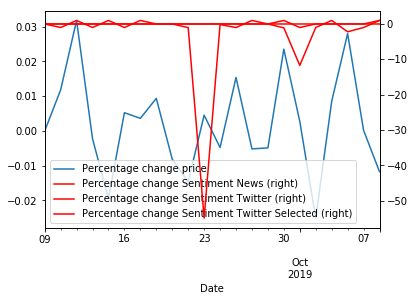

In [53]:
ax = plt.gca()

df_stock.plot(kind='line',y='Percentage change price',ax=ax)
df_stock.plot(kind='line',y='Percentage change Sentiment News', color='red', ax=ax, secondary_y = True)
df_stock.plot(kind='line',y='Percentage change Sentiment Twitter', color='red', ax=ax, secondary_y = True)
df_stock.plot(kind='line',y='Percentage change Sentiment Twitter Selected', color='red', ax=ax, secondary_y = True)

plt.show()

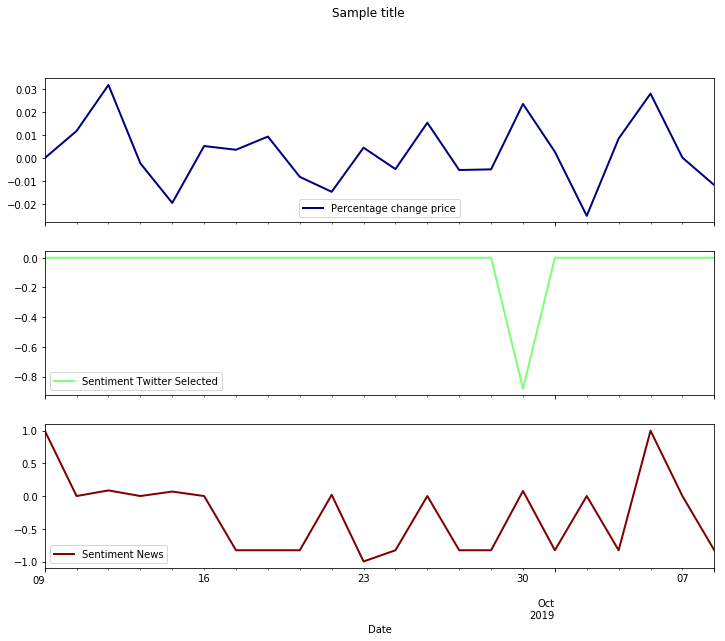

In [54]:
labels = ['Percentage change price','Sentiment Twitter Selected', 'Sentiment News']
dat = df_stock[labels]
axes = dat.plot(kind='line',rot=0,lw=2,colormap='jet',figsize=(12,10),
             title='Sample title', subplots=True, layout=(3,1))

plt.show()

In [0]:
df_stock_copy = df_stock.copy()
df_stock_copy.reset_index(level=0, inplace=True)

ohlc= df_stock_copy[['Date','Open', 'High', 'Low','Close']].copy()
ohlc
for i in range(0,len(ohlc['Date'])):
  ohlc['Date'][i] = ohlc['Date'][i].date().toordinal()
  

0

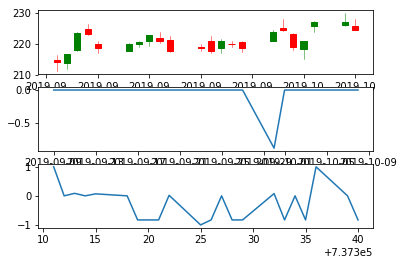

In [56]:
f1, ax = plt.subplots(3)
candlestick_ohlc(ax[0], ohlc.values, width=.6, colorup='green', colordown='red')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Creating SMA columns
ohlc['SMA5'] = ohlc["Close"].rolling(5).mean()
ohlc['SMA10'] = ohlc["Close"].rolling(10).mean()
ohlc['SMA20'] = ohlc["Close"].rolling(20).mean()
ohlc['SMA50'] = ohlc["Close"].rolling(50).mean()
ohlc['SMA100'] = ohlc["Close"].rolling(100).mean()
ohlc['SMA200'] = ohlc["Close"].rolling(200).mean()

#Plotting SMA columns
# ax.plot(ohlc['Date'], ohlc['SMA5'], color = 'blue', label = 'SMA5')
# ax.plot(ohlc['Date'], ohlc['SMA10'], color = 'blue', label = 'SMA10')
# ax.plot(ohlc['Date'], ohlc['SMA20'], color = 'blue', label = 'SMA20')
ax[0].plot(ohlc['Date'], ohlc['SMA50'], color = 'green', label = 'SMA50')
# ax.plot(ohlc.index, df['SMA100'], color = 'blue', label = 'SMA100')
ax[0].plot(ohlc['Date'], ohlc['SMA200'], color = 'blue', label = 'SMA200')

ax[1].plot(df_stock.index,df_stock['Sentiment Twitter Selected'])
ax[2].plot(ohlc['Date'],df_stock['Sentiment News'])

#plt.savefig('/content/new_image.png')
bytes_image = io.BytesIO()
plt.savefig(bytes_image, format='png')
bytes_image.seek(0)
#send_file(bytes_obj,attachment_filename='plot.png',mimetype='images/png')
#plt.show()